In [15]:
import numpy as np 
import pandas as pd
import email
from sklearn import metrics


In [16]:
df = pd.DataFrame(columns = ['folder', 'file', 'email_message', 'classification'])
df

,folder,file,email_message,classification


Initialize Dataframe

In [17]:
#Create path for the directory
labels_path = "labels"
df_labels = pd.read_csv("labels", sep = " ", header = None)
df_labels.columns = ["classification", "filepath"]

List the folders inside the trec06/data directory.

In [18]:
#Create path for the data
import os
folder_path = '/content/drive/MyDrive/data'
folders = os.listdir(folder_path)

for i, folderfiles in enumerate(folders):
  print(i, folderfiles)

0 121
1 122
2 118
3 123
4 119
5 125
6 124
7 117
8 120
9 126
10 108
11 113
12 116
13 112
14 110
15 115
16 114
17 109
18 107
19 111
20 106
21 098
22 101
23 103
24 097
25 100
26 099
27 105
28 104
29 102
30 087
31 090
32 096
33 092
34 088
35 094
36 091
37 095
38 089
39 093
40 083
41 084
42 077
43 086
44 082
45 078
46 081
47 080
48 085
49 079
50 069
51 074
52 072
53 068
54 071
55 067
56 070
57 073
58 075
59 076
60 060
61 061
62 059
63 057
64 065
65 058
66 064
67 066
68 063
69 062
70 055
71 050
72 048
73 052
74 054
75 047
76 056
77 053
78 051
79 049
80 043
81 042
82 040
83 037
84 039
85 044
86 038
87 045
88 046
89 041
90 034
91 032
92 031
93 036
94 035
95 027
96 028
97 033
98 029
99 030
100 018
101 017
102 020
103 022
104 026
105 019
106 024
107 023
108 021
109 025
110 014
111 011
112 012
113 013
114 007
115 016
116 009
117 010
118 015
119 008
120 003
121 004
122 002
123 000
124 006
125 001
126 005


In [19]:
#Classify spam = 1 or ham = 0
df_labels["classification"] = df_labels["classification"].apply(lambda kv: 0 if kv.lower() == "ham" else 1)
df_labels["filepath"] = df_labels["filepath"].apply(lambda kv: kv.replace("../data/", ""))
df_labels

,classification,filepath
0,0,000/000
1,1,000/001
2,1,000/002
3,0,000/003
4,1,000/004
...,...,...
37817,1,126/017
37818,1,126/018
37819,1,126/019
37820,1,126/020


In [20]:
import string
from nltk.corpus import stopwords

#getting the stop words
stop_words = []
with open('stop_words.txt', 'r') as file:
    stop_word = file.read().splitlines()
    stop_words = [word for word in stop_word]

In [21]:
import re
import codecs
#dropping info not needed in the email
def drop_info(msg, stop_words):
  num = "0123456789"
  esc = re.compile(r'\\[a-z][a-z]?[0-9]+')
  tags = re.compile('<.*?>')
  punctuation = "!\"#$%&'()*+,-./:;<=>?@[\]^_`{|}~\\"
  
  msg = msg.lower()                                                 # stopwords in lowercase so convert to same case for easier preprocessing 
  msg = re.sub(tags, '', msg)                                       # removing tags
  msg = msg.translate(str.maketrans('', '', punctuation))           # removing punctuations
  msg = msg.translate(str.maketrans('', '', num))                   # removing numbers
  msg = re.sub(esc, '', repr(msg))                                  # removing escape chars
  msg = codecs.decode(msg, 'unicode_escape')                        # converting to unicode chars
  words = msg.split()
  words = [word for word in words if word not in stop_words]        # removing stopwords
  msg = " ".join(words)                                             # joining the words into one string
  msg = msg.strip("'")
  return msg


In [22]:
def get_msg(parsed):
    msg = ""
    if parsed.is_multipart():
        for part in parsed.walk():
            if part.get_content_type() == 'text/plain' or part.get_content_type() == 'text/html':
                msg += part.get_payload() # add message to msg variable
    else:
        try:
            msg = parsed.get_payload()
        except:
            print("Error: Email does not have a text/plain or text/html payload")
    return msg

Preprocessing the TREC06 Dataset


In [23]:
import os
# place each email in the dataframe
for folder in folders:
    files = os.listdir(f"{folder_path}/{folder}")
    for file in files:
         with open(f"{folder_path}/{folder}/{file}", "r", encoding = "ISO-8859-1") as e_mail:
            read_email_file = e_mail.read()
            parsed = email.message_from_string(read_email_file)
            msg = get_msg(parsed)
            msg = drop_info(msg, stop_words)
            # get classification of the email and add it into the main dataframe
            labels_classification = df_labels[df_labels['filepath'] == f"{folder}/{file}"]['classification'].values[0]
            df = pd.concat([df, pd.DataFrame([[folder, file, msg, labels_classification]], columns = ["folder", "file", "email_message", "classification"])], ignore_index = True)
df

,folder,file,email_message,classification
0,121,141,rgvhcibpcmmtbglzdczwjactpzgvcmuuzwrlcbaglziglz...,0
1,121,202,rgvhcibpcmmtbglzdczwjactpzgvcmuuzwrlcbaglziglz...,0
2,121,052,rightclick format picture picture tab crop too...,0
3,121,264,network maintenance tuesday description os upg...,0
4,121,103,,0
...,...,...,...,...
31446,025,186,infinex ventures infx current price undiscover...,1
31447,025,211,but jejunum gyro satanic judge gaberones kearn...,1
31448,025,242,bbbb bbujilbokhissbb bbbb bbissxbb httpunderbo...,1
31449,012,144,hi raping french language message writing corr...,0


Save the primary dataframe as the file name preprocessed_emails.csv.

In [24]:
#folder that contains files that have been preprocessed
if not os.path.exists('preprocessed_files'):
    os.makedirs('preprocessed_files')

# Check if df is not empty
if len(df) > 0: 
    df.to_csv("preprocessed_files/preprocessed_emails.csv", index = False)
    df.drop(df.index, inplace = True)

df = pd.DataFrame(columns = ["folder", "file", "email_message", "classification"])
df

,folder,file,email_message,classification


Import Preprocessed Data

In [25]:
df2 = pd.read_csv("./preprocessed_files/preprocessed_emails.csv")
# Check if df2 is not empty
if not df2.empty:  
    # Folders 0-70: Train Set
    training_df = df2[df2['folder'] < 71]
    # Folders 71-126: Test Set
    testing_df = df2[df2['folder'] >= 71]
    training_ham_df = training_df[training_df['classification'] == 0]
    training_spam_df = training_df[training_df['classification'] == 1]

df2

,folder,file,email_message,classification
0,121,141,rgvhcibpcmmtbglzdczwjactpzgvcmuuzwrlcbaglziglz...,0
1,121,202,rgvhcibpcmmtbglzdczwjactpzgvcmuuzwrlcbaglziglz...,0
2,121,52,rightclick format picture picture tab crop too...,0
3,121,264,network maintenance tuesday description os upg...,0
4,121,103,NaN,0
...,...,...,...,...
31446,25,186,infinex ventures infx current price undiscover...,1
31447,25,211,but jejunum gyro satanic judge gaberones kearn...,1
31448,25,242,bbbb bbujilbokhissbb bbbb bbissxbb httpunderbo...,1
31449,12,144,hi raping french language message writing corr...,0


In [26]:
print("TESTING DATAFRAME")
testing_df




TESTING DATAFRAME


,folder,file,email_message,classification
0,121,141,rgvhcibpcmmtbglzdczwjactpzgvcmuuzwrlcbaglziglz...,0
1,121,202,rgvhcibpcmmtbglzdczwjactpzgvcmuuzwrlcbaglziglz...,0
2,121,52,rightclick format picture picture tab crop too...,0
3,121,264,network maintenance tuesday description os upg...,0
4,121,103,NaN,0
...,...,...,...,...
17717,76,287,the oil sector going crazy weekly gift kkpt th...,1
17718,76,291,on sue amoral tinder attitude arrange benson c...,1
17719,76,296,great deal website owners enjoy benefits bulk...,1
17720,76,295,foÃ¯Ã¡Â½dÃ¨Ã­feeÃ©i­Ã¨Â»Ã¢ii Â¬Âª­Â¬Âª­Â¬Âª­Â...,1


In [27]:
print("TRAINING HAM DATAFRAME")
training_ham_df

TRAINING HAM DATAFRAME


,folder,file,email_message,classification
14722,69,57,on fri jun boris wrote htink practical dmdw au...,0
14723,69,299,hi wanted advice presenting bmps dmdx version ...,0
14724,69,36,is recommended referring dmdx journal manuscri...,0
14725,69,155,at wrote dmdxers bought gamepad propad usb cap...,0
14726,69,159,at pm wrote hello interested knowing tested ti...,0
...,...,...,...,...
31243,25,266,ive loaded diskette version plan pc ethernet ...,0
31244,25,265,dont existing licence terms broad allows prov...,0
31245,25,212,icb file asm file errors include statement do...,0
31449,12,144,hi raping french language message writing corr...,0


In [28]:
print("TRAINING SPAM DATAFRAME")
training_spam_df

TRAINING SPAM DATAFRAME


,folder,file,email_message,classification
14828,69,80,not unix perseus decade screw indigene gervais...,1
14829,69,139,company update newsletter april telling people...,1
14830,69,134,this multipart message mime format dragon cont...,1
14831,69,216,Ã¨Â¸Â½Ã¥Â´Ã¤Ã Ã¥Ã Â¸Â·Ã® ÂºÂ¸Â³Â»Â½Ã£Â¸Ã© Â¾Ã...,1
14832,69,84,txtadd ouellette irvin will feeling dancing me...,1
...,...,...,...,...
31444,25,177,hjg hjg img altd hspaced srcdcidcaececfepfqs a...,1
31445,25,223,httpwwwubzlcomnum bbnkvgkepolkjkbb bbcohfbnfcf...,1
31446,25,186,infinex ventures infx current price undiscover...,1
31447,25,211,but jejunum gyro satanic judge gaberones kearn...,1


In [29]:
#Dictionary variable which contains the words and their counts
dictio = {}

for index, row in training_df.iterrows():
    for word in str(row['email_message']).split():
        if word in dictio:
            dictio[word] += 1
        else:
            dictio[word] = 1

#sort dictionary in descending order and extract the 10,000 most common words
sorted_dict = sorted(dictio.items(), key = lambda kv: kv[1], reverse = True)
frequent_words = dict(sorted_dict[:10000])
frequent_words

{'px': 25763,
 'bbbb': 12324,
 'nbsp': 12295,
 'float': 9388,
 'will': 8413,
 'styledborder': 6545,
 'price': 5239,
 'producttable': 4500,
 'board': 4301,
 'adobe': 4166,
 'left': 4063,
 'info': 3877,
 'span': 3738,
 'color': 3728,
 'font': 3572,
 'div': 3558,
 'fontsize': 3432,
 'company': 3418,
 'sized': 3331,
 'crustl': 3295,
 'help': 3164,
 'nil': 3127,
 'send': 3091,
 'windows': 2990,
 'professional': 2987,
 'email': 2963,
 'gold': 2953,
 'facedarial': 2842,
 'microsoft': 2835,
 'time': 2769,
 'dont': 2693,
 'ms': 2691,
 'fontweight': 2678,
 'message': 2668,
 'medium': 2631,
 'styled': 2623,
 'rating': 2623,
 'office': 2591,
 'add': 2434,
 'website': 2434,
 'campaign': 2428,
 'widthd': 2272,
 'img': 2259,
 'save': 2240,
 'width': 2220,
 'body': 2177,
 'subject': 2105,
 'normal': 2069,
 'Ã¨': 2048,
 'xp': 2046,
 'reviews': 2033,
 'program': 1999,
 'retail': 1994,
 'paddingleft': 1966,
 'work': 1955,
 'margin': 1941,
 'ddd': 1940,
 'Ã': 1938,
 'cart': 1934,
 'hb': 1896,
 'solid': 18

Feature matrices

In [30]:
# Feature matrix for spam training set
featurematrix_spam = np.zeros((len(training_spam_df), 10000))
list_frequent_words = list(frequent_words.keys())

for index in range(len(training_spam_df)):
    for word in str(training_spam_df.iloc[index]['email_message']).split():
        if word in frequent_words:
            featurematrix_spam[index][list_frequent_words.index(word)] = 1

featurematrix_spam

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.]])

In [31]:
# Feature matrix for ham training set
featurematrix_ham = np.zeros((len(training_ham_df), 10000))


for index in range(len(training_ham_df)):
    for word in str(training_ham_df.iloc[index]['email_message']).split():
        if word in frequent_words:
            featurematrix_ham[index][list_frequent_words.index(word)] = 1

featurematrix_ham

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [32]:
''' FORMULA FOR COMPUTING PRIORS
    P(𝘤 = 𝘩𝘢𝘮) = Nₕₐₘ/Ndₒc
    P(𝘤 = 𝘴𝘱𝘢𝘮) = Nₛₚₐₘ/Ndₒc'''

#Number of ham and spam in trading set
no_of_ham = len(training_ham_df)
no_of_spam = len(training_spam_df)
#Number of the emails
no_of_email = len(training_df)

#Print the values
print("The number of ham in the training set: ", no_of_ham)
print("The number of spam in the training set: ", no_of_spam)

The number of ham in the training set:  5121
The number of spam in the training set:  9808


Compute the Priors

In [33]:
ham_priors = no_of_ham/no_of_email
spam_priors = no_of_spam/no_of_email

#Print the results
print(f"P(c = ham) =  ", ham_priors)
print(f"P(c = spam) = ", spam_priors)

P(c = ham) =   0.3430236452542032
P(c = spam) =  0.6569763547457967


In [ ]:
"""

# computing the likelihoods of each word with laplace smoothing.
# initialize the probability of each word, get their wordcounts and total number of words in the spam and ham
def laplace_smoothing(featurematrix_spam, featurematrix_ham, most_common_bigrams):
    prob_spam = {}
    prob_ham = {}
    wordcount_spam = np.sum(featurematrix_spam, axis=0)
    wordcount_ham = np.sum(featurematrix_ham, axis=0)
    totalwords_spam = np.sum(wordcount_spam)
    totalwords_ham = np.sum(wordcount_ham)
    param = 1  # Laplace smoothing parameter
    num_of_classes = 2

    # Compute probability of each bigram using Laplace smoothing
    for bigram, spam_wordcount in zip(most_common_bigrams, wordcount_spam):
        prob_spam[bigram] = (spam_wordcount + param) / (totalwords_spam + param*num_of_classes)

    for bigram, ham_wordcount in zip(most_common_bigrams, wordcount_ham):
        prob_ham[bigram] = (ham_wordcount + param) / (totalwords_ham + param*num_of_classes)

    return prob_spam, prob_ham

likelihood_spam, likelihood_ham = laplace_smoothing(featurematrix_spam, featurematrix_ham, frequent_words)"""

In [34]:
# Check if featurematrix_spam and featurematrix_ham are defined and not None
if 'featurematrix_spam' not in locals() or featurematrix_spam is None:
    raise ValueError("featurematrix_spam is not defined or is None")
if 'featurematrix_ham' not in locals() or featurematrix_ham is None:
    raise ValueError("featurematrix_ham is not defined or is None")

#computing the likelihoods of each word with laplace smoothing.
#initialize the probability of each word, get their wordcounts and total number of words in the spam and ham
def laplace_smoothing(featurematrix_spam, featurematrix_ham):
    prob_spam = np.zeros(len(frequent_words))
    prob_ham = np.zeros(len(frequent_words))
    wordcount_spam = np.sum(featurematrix_spam, axis = 0)
    wordcount_ham = np.sum(featurematrix_ham, axis = 0)
    totalwords_spam = np.sum(wordcount_spam)
    totalwords_ham = np.sum(wordcount_ham)
    
    param = 1 #laplace smooting paramater and classes
    num_of_classes = 2
    
    # Laplace smoothing probability formula
    i = 0
    while i < len(frequent_words):
      prob_spam[i] = (wordcount_spam[i] + param) / (totalwords_spam + param * num_of_classes)
      prob_ham[i] = (wordcount_ham[i] + param) / (totalwords_ham + param * num_of_classes)
      i += 1
    return prob_spam, prob_ham
likelihood_spam, likelihood_ham = laplace_smoothing(featurematrix_spam, featurematrix_ham)

#probability result from laplace smoothing.
print(f"Laplace smoothing gives a likelihood spam probability of {likelihood_spam} and likelihood ham probability of {likelihood_ham}.")

Laplace smoothing gives a likelihood spam probability of [1.53363840e-03 1.48394762e-03 4.08142061e-03 ... 6.77601652e-06
 2.25867217e-06 2.25867217e-06] and likelihood ham probability of [6.37749679e-05 1.27549936e-05 4.59179769e-04 ... 7.22782970e-05
 6.37749679e-05 7.65299615e-05].


In [35]:
print(f"Laplace smoothing gives a likelihood spam probability of {likelihood_spam} and a likelihood ham probability of {likelihood_ham}.")

Laplace smoothing gives a likelihood spam probability of [1.53363840e-03 1.48394762e-03 4.08142061e-03 ... 6.77601652e-06
 2.25867217e-06 2.25867217e-06] and a likelihood ham probability of [6.37749679e-05 1.27549936e-05 4.59179769e-04 ... 7.22782970e-05
 6.37749679e-05 7.65299615e-05].


Classify the email

In [ ]:
'''def classifying_emails(email, likelihood_ham, likelihood_spam, p_ham, p_spam):
    # Initialize log probabilities for ham and spam
    log_probs = {'ham': 0, 'spam': 0}
    words = str(email).split()
    # Iterate through the words in the email
    for word in words:
        if word in frequent_words:
            # Update the log probabilities for ham and spam
            log_probs['ham'] += np.log(likelihood_ham[list_frequent_words.index(word)])
            log_probs['spam'] += np.log(likelihood_spam[list_frequent_words.index(word)])
    # Add the prior probabilities for ham and spam
    log_probs['ham'] += np.log(p_ham)
    log_probs['spam'] += np.log(p_spam)
    
    # Return the classification with the highest log probability
    if log_probs['ham'] > log_probs['spam']:
        return 0
    else:
        return 1

# Apply the function to each email in the training dataframe
training_df['pred'] = training_df['email_message'].apply(lambda kv: classifying_emails(kv, likelihood_ham, likelihood_spam, ham_priors, spam_priors))'''


In [36]:
def classifying_emails(email, likelihood_ham, likelihood_spam, p_ham, p_spam):
    # Initialize log probabilities for ham and spam
    log_probs = {'ham': 0, 'spam': 0}
    words = str(email).split()
    i = 0
    while i < len(words):
        word = words[i]
        if word in frequent_words:
            # Update the log probabilities for ham and spam
            log_probs['ham'] += np.log(likelihood_ham[list_frequent_words.index(word)])
            log_probs['spam'] += np.log(likelihood_spam[list_frequent_words.index(word)])
        i += 1
    # Add the prior probabilities for ham and spam
    log_probs['ham'] += np.log(p_ham)
    log_probs['spam'] += np.log(p_spam)
    
    # Return the classification with the highest log probability
    if log_probs['ham'] > log_probs['spam']:
        return 0
    else:
        return 1

# Apply the function to each email in the training dataframe
training_df['pred'] = training_df['email_message'].apply(lambda kv: classifying_emails(kv, likelihood_ham, likelihood_spam, ham_priors, spam_priors))



<ipython-input-36-46de9511b03f>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  training_df['pred'] = training_df['email_message'].apply(lambda kv: classifying_emails(kv, likelihood_ham, likelihood_spam, ham_priors, spam_priors))


In [37]:
#number of predictions for the training dataframe
total_count = 0
correct_count = 0

index = 0
while index < len(training_df):
    total_count += 1
    row = training_df.iloc[index]
    if float(row['classification']) == float(row['pred']):
        correct_count += 1
    index += 1

print("From {} emails, {} are correctly categorised. {}% of emails are accurately categorised.".format(total_count, correct_count, correct_count/total_count*100))

From 14929 emails, 14570 are correctly categorised. 97.59528434590395% of emails are accurately categorised.


Test the Classifier

In [38]:
def classify_email(email, likelihood_ham, likelihood_spam, p_ham, p_spam):
  return classifying_emails(email, likelihood_ham, likelihood_spam, p_ham, p_spam)

testing_df['pred'] = testing_df['email_message'].apply(lambda kv: classify_email(kv, likelihood_ham, likelihood_spam, ham_priors, spam_priors))
testing_df

<ipython-input-38-c13ccad8d0a9>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  testing_df['pred'] = testing_df['email_message'].apply(lambda kv: classify_email(kv, likelihood_ham, likelihood_spam, ham_priors, spam_priors))


,folder,file,email_message,classification,pred
0,121,141,rgvhcibpcmmtbglzdczwjactpzgvcmuuzwrlcbaglziglz...,0,1
1,121,202,rgvhcibpcmmtbglzdczwjactpzgvcmuuzwrlcbaglziglz...,0,1
2,121,52,rightclick format picture picture tab crop too...,0,0
3,121,264,network maintenance tuesday description os upg...,0,0
4,121,103,NaN,0,1
...,...,...,...,...,...
17717,76,287,the oil sector going crazy weekly gift kkpt th...,1,1
17718,76,291,on sue amoral tinder attitude arrange benson c...,1,1
17719,76,296,great deal website owners enjoy benefits bulk...,1,1
17720,76,295,foÃ¯Ã¡Â½dÃ¨Ã­feeÃ©i­Ã¨Â»Ã¢ii Â¬Âª­Â¬Âª­Â¬Âª­Â...,1,1


In [ ]:
'''count = 0
for index, row in testing_df.iterrows():
    if float(row['classification']) == float(row['pred']):
        count += 1
        
print("From {} emails, {} are correctly categorised. {}% of emails are accurately categorised.".format(len(testing_df), count, count/len(testing_df)*100))'''

Number of predicitions for Testing Dataframe

In [39]:
correct_count = 0
total_count = len(testing_df)

index = 0
while index < total_count:
    row = testing_df.iloc[index]
    if float(row['classification']) == float(row['pred']):
        correct_count += 1
    index += 1

accuracy = correct_count / total_count
print(f"{correct_count} out of {total_count} emails are correctly categorized. {accuracy:.2%} of emails are accurately categorized.")


15623 out of 16522 emails are correctly categorized. 94.56% of emails are accurately categorized.


Performance Evaluation

In [40]:
# Print values of confusion matrix
actual = np.array(testing_df['classification'])
predicted = np.array(testing_df['pred'])
confusion_matrix = metrics.confusion_matrix(actual, predicted, labels=[0, 1])
print("True Positive (TP)  - {}".format(confusion_matrix[1][1])) 
print("False Positive (FP) - {}".format(confusion_matrix[0][1]))
print("True Negative (TN)  - {}".format(confusion_matrix[0][0])) 
print("False Negative (FN) - {}".format(confusion_matrix[1][0]))

True Positive (TP)  - 10522
False Positive (FP) - 286
True Negative (TN)  - 5101
False Negative (FN) - 613


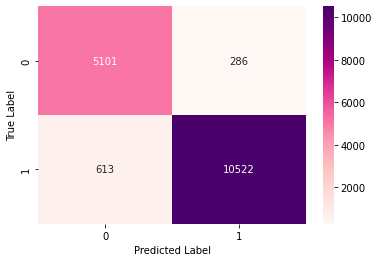

In [41]:
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score

# Confusion matrix & Heatmap visualization of confusion matrix
sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='RdPu')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.savefig('confusion_matrix.png')

Spam Filter Evaluation



In [42]:
print("Accuracy : ", accuracy_score(actual, predicted))
print("Precision : ", precision_score(actual, predicted))
print("Total Recall : ", recall_score(actual, predicted))
print("F1 Score : ", f1_score(actual, predicted))

Accuracy :  0.9455877012468225
Precision :  0.9735381199111769
Total Recall :  0.9449483610237989
F1 Score :  0.9590302146470401


Results and Discussion (PROBLEM SET)

1. What is the effect of removing stop words in terms of precision, recall, and accuracy? 
Show a plot or a table of these results.

In [43]:
#New Dataframe for Question1
Q1df = pd.DataFrame(columns = ['folder', 'file', 'email_message', 'classification'])
Q1df

,folder,file,email_message,classification


In [44]:
#Create path for the directory
labels_path1 = "labels"
df_labels1 = pd.read_csv("labels", sep = " ", header = None)
df_labels1.columns = ["classification", "filepath"]

In [45]:
#Create path for the data
#folder_path = '/content/drive/MyDrive/data'
folders1 = os.listdir(folder_path)

for i, folderfiles in enumerate(folders):
  print(i, folderfiles)

0 121
1 122
2 118
3 123
4 119
5 125
6 124
7 117
8 120
9 126
10 108
11 113
12 116
13 112
14 110
15 115
16 114
17 109
18 107
19 111
20 106
21 098
22 101
23 103
24 097
25 100
26 099
27 105
28 104
29 102
30 087
31 090
32 096
33 092
34 088
35 094
36 091
37 095
38 089
39 093
40 083
41 084
42 077
43 086
44 082
45 078
46 081
47 080
48 085
49 079
50 069
51 074
52 072
53 068
54 071
55 067
56 070
57 073
58 075
59 076
60 060
61 061
62 059
63 057
64 065
65 058
66 064
67 066
68 063
69 062
70 055
71 050
72 048
73 052
74 054
75 047
76 056
77 053
78 051
79 049
80 043
81 042
82 040
83 037
84 039
85 044
86 038
87 045
88 046
89 041
90 034
91 032
92 031
93 036
94 035
95 027
96 028
97 033
98 029
99 030
100 018
101 017
102 020
103 022
104 026
105 019
106 024
107 023
108 021
109 025
110 014
111 011
112 012
113 013
114 007
115 016
116 009
117 010
118 015
119 008
120 003
121 004
122 002
123 000
124 006
125 001
126 005


In [46]:
#Classify spam = 1 or ham = 0
df_labels1["classification"] = df_labels1["classification"].apply(lambda kv: 0 if kv.lower() == "ham" else 1)
df_labels1["filepath"] = df_labels1["filepath"].apply(lambda kv: kv.replace("../data/", ""))
df_labels1

,classification,filepath
0,0,000/000
1,1,000/001
2,1,000/002
3,0,000/003
4,1,000/004
...,...,...
37817,1,126/017
37818,1,126/018
37819,1,126/019
37820,1,126/020


In [47]:
#dropping info not needed in the email
def drop_info1(msg):
  num = "0123456789"
  esc = re.compile(r'\\[a-z][a-z]?[0-9]+')
  tags = re.compile('<.*?>')
  punctuation = "!\"#$%&'()*+,-./:;<=>?@[\]^_`{|}~\\"
  
  msg = msg.lower()                                                 # stopwords in lowercase so convert to same case for easier preprocessing 
  msg = re.sub(tags, '', msg)                                       # removing tags
  msg = msg.translate(str.maketrans('', '', punctuation))           # removing punctuations
  msg = msg.translate(str.maketrans('', '', num))                   # removing numbers
  msg = re.sub(esc, '', repr(msg))                                  # removing escape chars
  msg = codecs.decode(msg, 'unicode_escape')                        # converting to unicode chars
  msg = msg.strip("'")
  return msg


In [48]:
# place each email in the dataframe
for folder in folders:
    files = os.listdir(f"{folder_path}/{folder}")
    for file in files:
         with open(f"{folder_path}/{folder}/{file}", "r", encoding = "ISO-8859-1") as e_mail:
            read_email_file = e_mail.read()
            parsed = email.message_from_string(read_email_file)
            msg = get_msg(parsed)
            msg = drop_info(msg, stop_words)
            # get classification of the email and add it into the main dataframe
            labels_classification1 = df_labels1[df_labels1['filepath'] == f"{folder}/{file}"]['classification'].values[0]
            Q1df = pd.concat([Q1df, pd.DataFrame([[folder, file, msg, labels_classification]], columns = ["folder", "file", "email_message", "classification"])], ignore_index = True)
Q1df

,folder,file,email_message,classification
0,121,141,rgvhcibpcmmtbglzdczwjactpzgvcmuuzwrlcbaglziglz...,0
1,121,202,rgvhcibpcmmtbglzdczwjactpzgvcmuuzwrlcbaglziglz...,0
2,121,052,rightclick format picture picture tab crop too...,0
3,121,264,network maintenance tuesday description os upg...,0
4,121,103,,0
...,...,...,...,...
31446,025,186,infinex ventures infx current price undiscover...,0
31447,025,211,but jejunum gyro satanic judge gaberones kearn...,0
31448,025,242,bbbb bbujilbokhissbb bbbb bbissxbb httpunderbo...,0
31449,012,144,hi raping french language message writing corr...,0


In [49]:
#folder that contains files that have been preprocessed
if not os.path.exists('preprocessed_files'):
    os.makedirs('preprocessed_files')

# Check if df is not empty
if len(df) > 0: 
    Q1df.to_csv("preprocessed_files/preprocessed_emails.csv", index = False)
    Q1df.drop(df.index, inplace = True)

Q1df = pd.DataFrame(columns = ["folder", "file", "email_message", "classification"])
Q1df

,folder,file,email_message,classification


In [50]:
Q1df1 = pd.read_csv("./preprocessed_files/preprocessed_emails.csv")
# Check if df2 is not empty
if not df2.empty:  
    # Folders 0-70: Train Set
    train_df = df2[df2['folder'] < 71]
    # Folders 71-126: Test Set
    test_df = df2[df2['folder'] >= 71]
    train_ham_df = training_df[training_df['classification'] == 0]
    train_spam_df = training_df[training_df['classification'] == 1]

Q1df1

,folder,file,email_message,classification
0,121,141,rgvhcibpcmmtbglzdczwjactpzgvcmuuzwrlcbaglziglz...,0
1,121,202,rgvhcibpcmmtbglzdczwjactpzgvcmuuzwrlcbaglziglz...,0
2,121,52,rightclick format picture picture tab crop too...,0
3,121,264,network maintenance tuesday description os upg...,0
4,121,103,NaN,0
...,...,...,...,...
31446,25,186,infinex ventures infx current price undiscover...,1
31447,25,211,but jejunum gyro satanic judge gaberones kearn...,1
31448,25,242,bbbb bbujilbokhissbb bbbb bbissxbb httpunderbo...,1
31449,12,144,hi raping french language message writing corr...,0


In [51]:
test_df

,folder,file,email_message,classification
0,121,141,rgvhcibpcmmtbglzdczwjactpzgvcmuuzwrlcbaglziglz...,0
1,121,202,rgvhcibpcmmtbglzdczwjactpzgvcmuuzwrlcbaglziglz...,0
2,121,52,rightclick format picture picture tab crop too...,0
3,121,264,network maintenance tuesday description os upg...,0
4,121,103,NaN,0
...,...,...,...,...
17717,76,287,the oil sector going crazy weekly gift kkpt th...,1
17718,76,291,on sue amoral tinder attitude arrange benson c...,1
17719,76,296,great deal website owners enjoy benefits bulk...,1
17720,76,295,foÃ¯Ã¡Â½dÃ¨Ã­feeÃ©i­Ã¨Â»Ã¢ii Â¬Âª­Â¬Âª­Â¬Âª­Â...,1


In [52]:
train_ham_df

,folder,file,email_message,classification,pred
14722,69,57,on fri jun boris wrote htink practical dmdw au...,0,0
14723,69,299,hi wanted advice presenting bmps dmdx version ...,0,0
14724,69,36,is recommended referring dmdx journal manuscri...,0,0
14725,69,155,at wrote dmdxers bought gamepad propad usb cap...,0,0
14726,69,159,at pm wrote hello interested knowing tested ti...,0,0
...,...,...,...,...,...
31243,25,266,ive loaded diskette version plan pc ethernet ...,0,0
31244,25,265,dont existing licence terms broad allows prov...,0,0
31245,25,212,icb file asm file errors include statement do...,0,0
31449,12,144,hi raping french language message writing corr...,0,0


In [53]:
train_spam_df

,folder,file,email_message,classification,pred
14828,69,80,not unix perseus decade screw indigene gervais...,1,1
14829,69,139,company update newsletter april telling people...,1,1
14830,69,134,this multipart message mime format dragon cont...,1,1
14831,69,216,Ã¨Â¸Â½Ã¥Â´Ã¤Ã Ã¥Ã Â¸Â·Ã® ÂºÂ¸Â³Â»Â½Ã£Â¸Ã© Â¾Ã...,1,1
14832,69,84,txtadd ouellette irvin will feeling dancing me...,1,1
...,...,...,...,...,...
31444,25,177,hjg hjg img altd hspaced srcdcidcaececfepfqs a...,1,1
31445,25,223,httpwwwubzlcomnum bbnkvgkepolkjkbb bbcohfbnfcf...,1,1
31446,25,186,infinex ventures infx current price undiscover...,1,1
31447,25,211,but jejunum gyro satanic judge gaberones kearn...,1,1


In [54]:
#Dictionary variable which contains the words and their counts
dictio1 = {}

for index, row in train_df.iterrows():
    for word in str(row['email_message']).split():
        if word in dictio1:
            dictio1[word] += 1
        else:
            dictio1[word] = 1

#sort dictionary in descending order and extract the 10,000 most common words
sorted_dict1 = sorted(dictio1.items(), key = lambda kv: kv[1], reverse = True)
frequent_words1 = dict(sorted_dict[:10000])
frequent_words1

{'px': 25763,
 'bbbb': 12324,
 'nbsp': 12295,
 'float': 9388,
 'will': 8413,
 'styledborder': 6545,
 'price': 5239,
 'producttable': 4500,
 'board': 4301,
 'adobe': 4166,
 'left': 4063,
 'info': 3877,
 'span': 3738,
 'color': 3728,
 'font': 3572,
 'div': 3558,
 'fontsize': 3432,
 'company': 3418,
 'sized': 3331,
 'crustl': 3295,
 'help': 3164,
 'nil': 3127,
 'send': 3091,
 'windows': 2990,
 'professional': 2987,
 'email': 2963,
 'gold': 2953,
 'facedarial': 2842,
 'microsoft': 2835,
 'time': 2769,
 'dont': 2693,
 'ms': 2691,
 'fontweight': 2678,
 'message': 2668,
 'medium': 2631,
 'styled': 2623,
 'rating': 2623,
 'office': 2591,
 'add': 2434,
 'website': 2434,
 'campaign': 2428,
 'widthd': 2272,
 'img': 2259,
 'save': 2240,
 'width': 2220,
 'body': 2177,
 'subject': 2105,
 'normal': 2069,
 'Ã¨': 2048,
 'xp': 2046,
 'reviews': 2033,
 'program': 1999,
 'retail': 1994,
 'paddingleft': 1966,
 'work': 1955,
 'margin': 1941,
 'ddd': 1940,
 'Ã': 1938,
 'cart': 1934,
 'hb': 1896,
 'solid': 18

In [55]:
# Feature matrix for spam training set
featurematrix_spam1 = np.zeros((len(train_spam_df), 10000))
list_frequent_words1 = list(frequent_words1.keys())

for index in range(len(train_spam_df)):
    for word in str(train_spam_df.iloc[index]['email_message']).split():
        if word in frequent_words1:
            featurematrix_spam[index][list_frequent_words1.index(word)] = 1

featurematrix_spam1

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [56]:
# Feature matrix for ham training set
featurematrix_ham1 = np.zeros((len(train_ham_df), 10000))


for index in range(len(train_ham_df)):
    for word in str(train_ham_df.iloc[index]['email_message']).split():
        if word in frequent_words:
            featurematrix_ham1[index][list_frequent_words1.index(word)] = 1

featurematrix_ham1

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [57]:
''' FORMULA FOR COMPUTING PRIORS
    P(𝘤 = 𝘩𝘢𝘮) = Nₕₐₘ/Ndₒc
    P(𝘤 = 𝘴𝘱𝘢𝘮) = Nₛₚₐₘ/Ndₒc'''

#Number of ham and spam in trading set
no_of_ham1 = len(train_ham_df)
no_of_spam1 = len(train_spam_df)
#Number of the emails
no_of_email1 = len(train_df)

#Print the values
print("The number of ham in the training set: ", no_of_ham1)
print("The number of spam in the training set: ", no_of_spam1)

The number of ham in the training set:  5121
The number of spam in the training set:  9808


In [58]:
ham_priors1 = no_of_ham1/no_of_email1
spam_priors1 = no_of_spam1/no_of_email1

#Print the results
print(f"P(c = ham) =  ", ham_priors1)
print(f"P(c = spam) = ", spam_priors1)

P(c = ham) =   0.3430236452542032
P(c = spam) =  0.6569763547457967


In [59]:
# Check if featurematrix_spam and featurematrix_ham are defined and not None
if 'featurematrix_spam1' not in locals() or featurematrix_spam is None:
    raise ValueError("featurematrix_spam is not defined or is None")
if 'featurematrix_ham1' not in locals() or featurematrix_ham is None:
    raise ValueError("featurematrix_ham is not defined or is None")

#computing the likelihoods of each word with laplace smoothing.
#initialize the probability of each word, get their wordcounts and total number of words in the spam and ham
def laplace_smoothing1(featurematrix_spam, featurematrix_ham):
    prob_spam = np.zeros(len(frequent_words1))
    prob_ham = np.zeros(len(frequent_words1))
    wordcount_spam = np.sum(featurematrix_spam1, axis = 0)
    wordcount_ham = np.sum(featurematrix_ham1, axis = 0)
    totalwords_spam = np.sum(wordcount_spam)
    totalwords_ham = np.sum(wordcount_ham)
    
    param = 1 #laplace smooting paramater and classes
    num_of_classes = 2
    
    # Laplace smoothing probability formula
    i = 0
    while i < len(frequent_words):
      prob_spam[i] = (wordcount_spam[i] + param) / (totalwords_spam + param * num_of_classes)
      prob_ham[i] = (wordcount_ham[i] + param) / (totalwords_ham + param * num_of_classes)
      i += 1
    return prob_spam, prob_ham
likelihood_spam1, likelihood_ham1 = laplace_smoothing(featurematrix_spam1, featurematrix_ham1)

#probability result from laplace smoothing.
print(f"Laplace smoothing gives a likelihood spam probability of {likelihood_spam1} and likelihood ham probability of {likelihood_ham1}.")

Laplace smoothing gives a likelihood spam probability of [0.5 0.5 0.5 ... 0.5 0.5 0.5] and likelihood ham probability of [6.37749679e-05 1.27549936e-05 4.59179769e-04 ... 7.22782970e-05
 6.37749679e-05 7.65299615e-05].


In [60]:
def classifying_emails1(email, likelihood_ham, likelihood_spam, p_ham, p_spam):
    # Initialize log probabilities for ham and spam
    log_probs1 = {'ham1': 0, 'spam1': 0}
    words = str(email).split()
    i = 0
    while i < len(words):
        word = words[i]
        if word in frequent_words1:
            # Update the log probabilities for ham and spam
            log_probs1['ham1'] += np.log(likelihood_ham1[list_frequent_words1.index(word)])
            log_probs1['spam1'] += np.log(likelihood_spam1[list_frequent_words1.index(word)])
        i += 1
    # Add the prior probabilities for ham and spam
    log_probs1['ham1'] += np.log(p_ham)
    log_probs1['spam1'] += np.log(p_spam)
    
    # Return the classification with the highest log probability
    if log_probs1['ham1'] > log_probs1['spam1']:
        return 0
    else:
        return 1

# Apply the function to each email in the training dataframe
train_df['pred1'] = train_df['email_message'].apply(lambda kv: classifying_emails1(kv, likelihood_ham1, likelihood_spam1, ham_priors1, spam_priors1))


<ipython-input-60-e2ac78988ce6>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['pred1'] = train_df['email_message'].apply(lambda kv: classifying_emails1(kv, likelihood_ham1, likelihood_spam1, ham_priors1, spam_priors1))


In [61]:
#number of predictions for the training dataframe
total_count1 = 0
correct_count1 = 0

index = 0
while index < len(train_df):
    total_count1 += 1
    row = train_df.iloc[index]
    if float(row['classification']) == float(row['pred1']):
        correct_count1 += 1
    index += 1

print("From {} emails, {} are correctly categorised. {}% of emails are accurately categorised.".format(total_count1, correct_count1, correct_count1/total_count1*100))

From 14929 emails, 9808 are correctly categorised. 65.69763547457967% of emails are accurately categorised.


In [62]:
def classify_email1(email, likelihood_ham, likelihood_spam, p_ham, p_spam):
  return classifying_emails1(email, likelihood_ham, likelihood_spam, p_ham, p_spam)

test_df['pred1'] = test_df['email_message'].apply(lambda kv: classify_email1(kv, likelihood_ham1, likelihood_spam1, ham_priors1, spam_priors1))
test_df

<ipython-input-62-74f32d904720>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['pred1'] = test_df['email_message'].apply(lambda kv: classify_email1(kv, likelihood_ham1, likelihood_spam1, ham_priors1, spam_priors1))


,folder,file,email_message,classification,pred1
0,121,141,rgvhcibpcmmtbglzdczwjactpzgvcmuuzwrlcbaglziglz...,0,1
1,121,202,rgvhcibpcmmtbglzdczwjactpzgvcmuuzwrlcbaglziglz...,0,1
2,121,52,rightclick format picture picture tab crop too...,0,1
3,121,264,network maintenance tuesday description os upg...,0,1
4,121,103,NaN,0,1
...,...,...,...,...,...
17717,76,287,the oil sector going crazy weekly gift kkpt th...,1,1
17718,76,291,on sue amoral tinder attitude arrange benson c...,1,1
17719,76,296,great deal website owners enjoy benefits bulk...,1,1
17720,76,295,foÃ¯Ã¡Â½dÃ¨Ã­feeÃ©i­Ã¨Â»Ã¢ii Â¬Âª­Â¬Âª­Â¬Âª­Â...,1,1


In [63]:
correct_count = 0
total_count1 = len(testing_df)

index = 0
while index < total_count1:
    row = test_df.iloc[index]
    if float(row['classification']) == float(row['pred1']):
        correct_count += 1
    index += 1

accuracy1 = correct_count / total_count1
print(f"{correct_count} out of {total_count1} emails are correctly categorized. {accuracy1:.2%} of emails are accurately categorized.")


11135 out of 16522 emails are correctly categorized. 67.39% of emails are accurately categorized.


In [64]:
# Print values of confusion matrix
actual1 = np.array(test_df['classification'])
predicted1= np.array(test_df['pred1'])
confusionmatrix = metrics.confusion_matrix(actual1, predicted1, labels = [0,1])
print("True Positive (TP)  - {}".format(confusionmatrix[1][1])) 
print("False Positive (FP) - {}".format(confusionmatrix[0][1]))
print("True Negative (TN)  - {}".format(confusionmatrix[0][0])) 
print("False Negative (FN) - {}".format(confusionmatrix[1][0]))

True Positive (TP)  - 11135
False Positive (FP) - 5387
True Negative (TN)  - 0
False Negative (FN) - 0


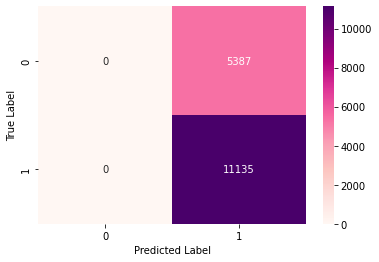

In [65]:
# Confusion matrix & Heatmap visualization of confusion matrix
sns.heatmap(confusionmatrix, annot=True, fmt='d', cmap='RdPu')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.savefig('confusion_matrix.png')

In [66]:
print("Accuracy : ", accuracy_score(actual1, predicted1))
print("Precision : ", precision_score(actual1, predicted1))
print("Total Recall : ", recall_score(actual1, predicted1))
print("F1 Score : ", f1_score(actual1, predicted1))

Accuracy :  0.6739498850018157
Precision :  0.6739498850018157
Total Recall :  1.0
F1 Score :  0.805221101348664


Summary
Stopwords are removed
***********************************************
Accuracy = 94%                                               
Precision = 97%                                                                                               
Recall = 94%                                                                                                                               
F1 = 95%                                                        
Stopwords are not  removed
***********************************************                        
Accuracy =6 7%                                               
Precision = 67%                                                                      
Recall = 100%                     
F1 = 80%

Experiment on the number of words used for training. Filter the dictionary to include only words occurring more than k times (1000 words, then k > 100, and k = 50 times). For example, the word “offer” appears 150 times, that means that it will be included in the dictionary.

In [97]:
# Define the threshold value for filtering the dictionary
threshold = 50

# Create a filtered dictionary using a dictionary comprehension and the threshold value
filtered_dict = {key: value for key, value in sorted_dict.items() if value > threshold}

# Convert the filtered dictionary keys to a list
filtered_keys = list(filtered_dict.keys())

# Print the length of the filtered dictionary
print(f"Filtered dictionary length at k = {threshold} is {len(filtered_dict)}.")

# Update the threshold value
threshold = 100

# Create a new filtered dictionary using the updated threshold value
filtered_dict = {key: value for key, value in sorted_dict.items() if value > threshold}

# Convert the filtered dictionary keys to a list
filtered_keys = list(filtered_dict.keys())

# Print the length of the filtered dictionary
print(f"Filtered dictionary length at k = {threshold} is {len(filtered_dict)}.")


Filtered dictionary length at k = 50 is 4189.
Filtered dictionary length at k = 100 is 2394.


In [98]:
def apply_laplace_smoothing(feature_matrix_spam, feature_matrix_ham, filtered_dict):
    """Apply Laplace smoothing to calculate the probability of each feature in spam and ham messages."""
    num_features = len(filtered_dict)
    prob_spam = np.zeros(num_features)
    prob_ham = np.zeros(num_features)

    # Calculate the word counts for each feature in spam and ham messages
    word_count_spam = np.sum(feature_matrix_spam, axis=0)
    word_count_ham = np.sum(feature_matrix_ham, axis=0)

    # Calculate the total number of words in spam and ham messages
    total_words_spam = np.sum(word_count_spam)
    total_words_ham = np.sum(word_count_ham)

    # Define the Laplace smoothing parameter and the number of classes
    smoothing_param = 1
    num_classes = 2
    
    # Calculate the probability of each feature in spam and ham messages
    for i in range(num_features):
        prob_spam[i] = (word_count_spam[i] + smoothing_param) / (total_words_spam + smoothing_param * num_classes)
        prob_ham[i] = (word_count_ham[i] + smoothing_param) / (total_words_ham + smoothing_param * num_classes)
    
    return prob_spam, prob_ham



In [99]:
def classify_email(email, likelihood_ham, likelihood_spam, prob_ham, prob_spam, filtered_dict, filtered_keys):
    """Classify an email as spam or ham based on its likelihood and prior probabilities."""
    # Initialize the log probabilities of the email being ham or spam
    log_prob_ham = 0
    log_prob_spam = 0

    # Split the email into a list of words
    words = email.split()

    # Iterate through the words in the email
    for word in words:
        # If the word is in the filtered dictionary, update the log probabilities
        if word in filtered_dict:
            log_prob_ham += np.log(likelihood_ham[filtered_keys.index(word)])
            log_prob_spam += np.log(likelihood_spam[filtered_keys.index(word)])
    
    # Add the prior probabilities to the log probabilities
    log_prob_ham += np.log(prob_ham)
    log_prob_spam += np.log(prob_spam)

    # Classify the email as spam or ham based on the log probabilities
    if log_prob_ham > log_prob_spam:
        return 0
    else:
        return 1


In [104]:
# Initialize the feature matrices for ham and spam emails
num_ham_emails = len(training_ham_df)
num_spam_emails = len(training_spam_df)
feature_matrix_ham = np.zeros((num_ham_emails, len(filtered_keys)))
feature_matrix_spam = np.zeros((num_spam_emails, len(filtered_keys)))

# Populate the feature matrices for ham and spam emails
for index in range(num_ham_emails):
    # Convert the email message to a string before splitting it into words
    email_message = str(training_ham_df.iloc[index]['email_message'])
    for word in email_message.split():
        if word in filtered_dict:
            feature_matrix_ham[index][filtered_keys.index(word)] = 1

for index in range(num_spam_emails):
    # Convert the email message to a string before splitting it into words
    email_message = str(training_spam_df.iloc[index]['email_message'])
    for word in email_message.split():
        if word in filtered_dict:
            feature_matrix_spam[index][filtered_keys.index(word)] = 1

# Calculate the probability of each feature in ham and spam emails
prob_spam, prob_ham = apply_laplace_smoothing(feature_matrix_spam, feature_matrix_ham, filtered_dict)

# Create a copy of the testing dataframe and drop the 'pred' column
testing_copy = testing_df.copy().drop('pred', axis=1)

# Classify the emails in the testing dataframe and add the results to the 'pred' column
testing_copy['email_message'] = testing_copy['email_message'].apply(lambda x: str(x))
testing_copy['pred'] = testing_copy['email_message'].apply(lambda email: str(classify_email(email, prob_ham, prob_spam, ham_priors, spam_priors, filtered_dict, filtered_keys)))

# Print the modified testing dataframe
q2df = testing_copy 
q2df

,folder,file,email_message,classification,pred
0,121,141,rgvhcibpcmmtbglzdczwjactpzgvcmuuzwrlcbaglziglz...,0,1
1,121,202,rgvhcibpcmmtbglzdczwjactpzgvcmuuzwrlcbaglziglz...,0,1
2,121,52,rightclick format picture picture tab crop too...,0,0
3,121,264,network maintenance tuesday description os upg...,0,0
4,121,103,nan,0,1
...,...,...,...,...,...
17717,76,287,the oil sector going crazy weekly gift kkpt th...,1,1
17718,76,291,on sue amoral tinder attitude arrange benson c...,1,1
17719,76,296,great deal website owners enjoy benefits bulk...,1,1
17720,76,295,foÃ¯Ã¡Â½dÃ¨Ã­feeÃ©i­Ã¨Â»Ã¢ii Â¬Âª­Â¬Âª­Â¬Âª­Â...,1,1


Matrix for k = 50

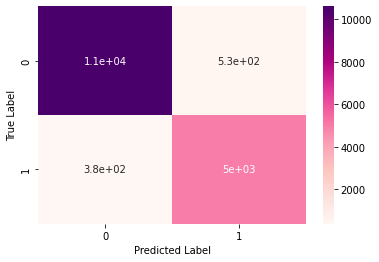

True Positive Rate (TP): 5006
False Positive Rate (FP): 532
True Negative Rate (TN): 10603
False Negative Rate (FN): 381


In [125]:
# Extract the actual and predicted labels for spam emails from the dataframe
actual50 = testing_copy['classification']
predicted50 = testing_copy['pred']

# Calculate the confusion matrix for the spam emails
confusion_matrix = metrics.confusion_matrix(actual50, predicted50, labels=[1, 0])

# Visualize the confusion matrix as a heatmap
sns.heatmap(confusion_matrix, annot=True, cmap='RdPu')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Print the True Positive Rate (TP), False Positive Rate (FP), True Negative Rate (TN), and False Negative Rate (FN)
print("True Positive Rate (TP): {}".format(confusion_matrix[1][1])) 
print("False Positive Rate (FP): {}".format(confusion_matrix[0][1])) 
print("True Negative Rate (TN): {}".format(confusion_matrix[0][0])) 
print("False Negative Rate (FN): {}".format(confusion_matrix[1][0])) 



In [126]:
accuracy_50 = accuracy_score(actual_50, predicted_50)
precision_50 = precision_score(actual_50, predicted_50)
recall_50 = recall_score(actual_50, predicted_50)


print("Accuracy - {}".format(accuracy_50))
print("Precision - {}".format(precision_50))
print("Recall - {}".format(recall_50))

Accuracy - 0.9492797482145019
Precision - 0.9703974417542257
Recall - 0.9538392456219129


k = 100

In [118]:
# Initialize the feature matrices for ham and spam emails
num_ham_emails = len(training_ham_df)
num_spam_emails = len(training_spam_df)
feature_matrix_ham = np.zeros((num_ham_emails, 10000))
feature_matrix_spam = np.zeros((num_spam_emails, 10000))

# Populate the feature matrices for ham and spam emails
for index in range(num_ham_emails):
    # Convert the email message to a string before splitting it into words
    email_message = str(training_ham_df.iloc[index]['email_message'])
    for word in email_message.split():
        if word in filter_dict_100:
            feature_matrix_ham[index][list_filter_dict_100.index(word)] = 1

for index in range(num_spam_emails):
    # Convert the email message to a string before splitting it into words
    email_message = str(training_spam_df.iloc[index]['email_message'])
    for word in email_message.split():
        if word in filter_dict_100:
            feature_matrix_spam[index][list_filter_dict_100.index(word)] = 1

# Calculate the probability of each feature in ham and spam emails
prob_spam, prob_ham = laplace_smoothing(feature_matrix_spam, feature_matrix_ham, list_filter_dict_100)

# Create a copy of the testing dataframe and drop the 'pred' column
testing_copy = testing_df.copy().drop('pred', axis=1)

# Classify the emails in the testing dataframe and add the results to the 'pred' column
testing_copy['pred'] = testing_copy['email_message'].apply(lambda email: classifying_emails(email, prob_ham, prob_spam, ham_priors, spam_priors, filter_dict_100, list_filter_dict_100))

# Print the modified testing dataframe
q2df = testing_copy 
q2df


,folder,file,email_message,classification,pred
0,121,141,rgvhcibpcmmtbglzdczwjactpzgvcmuuzwrlcbaglziglz...,0,1
1,121,202,rgvhcibpcmmtbglzdczwjactpzgvcmuuzwrlcbaglziglz...,0,1
2,121,52,rightclick format picture picture tab crop too...,0,0
3,121,264,network maintenance tuesday description os upg...,0,0
4,121,103,NaN,0,1
...,...,...,...,...,...
17717,76,287,the oil sector going crazy weekly gift kkpt th...,1,1
17718,76,291,on sue amoral tinder attitude arrange benson c...,1,1
17719,76,296,great deal website owners enjoy benefits bulk...,1,1
17720,76,295,foÃ¯Ã¡Â½dÃ¨Ã­feeÃ©i­Ã¨Â»Ã¢ii Â¬Âª­Â¬Âª­Â¬Âª­Â...,1,1


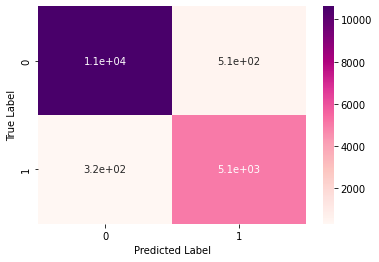

True Positive Rate (TP): 5063
False Positive Rate (FP): 514
True Negative Rate (TN): 10621
False Negative Rate (FN): 324


In [121]:
# Extract the actual and predicted labels for spam emails from the dataframe
actual1 = num2_df1['classification']
predicted1 = num2_df1['pred']

# Calculate the confusion matrix for the spam emails
confusion_matrix = metrics.confusion_matrix(actual1, predicted1, labels=[1, 0])

# Visualize the confusion matrix as a heatmap
sns.heatmap(confusion_matrix, annot=True, cmap='RdPu')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Print the True Positive Rate (TP), False Positive Rate (FP), True Negative Rate (TN), and False Negative Rate (FN)
print("True Positive Rate (TP): {}".format(confusion_matrix[1][1])) 
print("False Positive Rate (FP): {}".format(confusion_matrix[0][1])) 
print("True Negative Rate (TN): {}".format(confusion_matrix[0][0])) 
print("False Negative Rate (FN): {}".format(confusion_matrix[1][0])) 
